In [21]:
import pandas as pd
import cupy as cp

stock_df = pd.read_csv("./stocks.csv", index_col=0) # row timestamp column each stock
reset_df = stock_df.reset_index(drop=True)
change_df = reset_df.pct_change()
change_df.iloc[0] = 0
change_df = change_df + 1 # dataframe of price changes by the previous date


In [22]:
change_df

,Stock_1,Stock_2
0,1.0,1.0
1,2.0,0.5
2,0.5,2.0
3,2.0,0.5
4,0.5,2.0
5,2.0,0.5
6,0.5,2.0
7,2.0,0.5
8,0.5,2.0
9,2.0,0.5


In [23]:

def generate_matrix_gpu(sample_size, n):
    # GPU上でランダムな一様乱数を生成
    random_matrix = cp.random.rand(sample_size, n - 1)
    
    # 最後の列に1を追加
    ones_column = cp.ones((sample_size, 1))
    full_matrix = cp.concatenate((random_matrix, ones_column), axis=1)
    
    # 各行をソート
    sorted_matrix = cp.sort(full_matrix, axis=1)
    
    # 差分を計算
    result_matrix = cp.zeros((sample_size, n))
    result_matrix[:, 0] = sorted_matrix[:, 0]  # 最初の列はそのまま
    result_matrix[:, 1:] = sorted_matrix[:, 1:] - sorted_matrix[:, :-1]
    
    return result_matrix

# 使用例
sample_size = 5  # サンプル数
n = 4  # 列数

# 行列をGPUで生成
result_gpu = generate_matrix_gpu(sample_size, n)

# GPUメモリからホストメモリ（CPU）に移動して結果を確認
print("Generated Matrix (GPU):")
print(cp.asnumpy(result_gpu))

Generated Matrix (GPU):
[[0.2556044  0.40455246 0.27942138 0.06042176]
 [0.01657656 0.32559385 0.36102567 0.29680392]
 [0.41849697 0.25567727 0.20717781 0.11864795]
 [0.0593456  0.85686524 0.03747331 0.04631586]
 [0.34568014 0.10459102 0.12074522 0.42898362]]


In [31]:
n = change_df.shape[1] # number of stocks
T = change_df.shape[0]-1 # time series
alpha = 1 # alpha must be equal to or below 1 (alpha-exp-concavity)
sample_size = 10000000

revenues = cp.ones(T+1)
r_t = cp.array([1/n]*n) # ratio of stocks
change_matrix = [cp.array(row) for row in change_df.to_numpy()]
cum_rev = cp.ones(sample_size)
sample_matrix = generate_matrix_gpu(sample_size, n)

for t in range(1, T+1):
    stock_change = change_matrix[t]
    revenues[t] = stock_change @ r_t # record revenue of the calculated portfolio
    cum_rev *= (sample_matrix @ stock_change) # cumulative revenues of samples
    r_t = sample_matrix.T @ cum_rev**alpha / cp.sum(cum_rev**alpha) # calculate portfolio
    print(f"t={t}, r_t={r_t}")



t=1, r_t=[0.60007339 0.39992661]
t=2, r_t=[0.50004791 0.49995209]
t=3, r_t=[0.58914211 0.41085789]
t=4, r_t=[0.50003094 0.49996906]
t=5, r_t=[0.57937235 0.42062765]
t=6, r_t=[0.50001849 0.49998151]
t=7, r_t=[0.5707657 0.4292343]
t=8, r_t=[0.50000968 0.49999032]
t=9, r_t=[0.56326527 0.43673473]


In [ ]:
# use float64. may be needed when the matrix is too large

def generate_matrix_gpu(sample_size, n):
    # GPU上でランダムな一様乱数を生成 (float64に指定)
    random_matrix = cp.random.rand(sample_size, n - 1, dtype=cp.float64)
    
    # 最後の列に1を追加 (float64)
    ones_column = cp.ones((sample_size, 1), dtype=cp.float64)
    full_matrix = cp.concatenate((random_matrix, ones_column), axis=1)
    
    # 各行をソート
    sorted_matrix = cp.sort(full_matrix, axis=1)
    
    # 差分を計算
    result_matrix = cp.zeros((sample_size, n), dtype=cp.float64)
    result_matrix[:, 0] = sorted_matrix[:, 0]  # 最初の列はそのまま
    result_matrix[:, 1:] = sorted_matrix[:, 1:] - sorted_matrix[:, :-1]
    
    return result_matrix

# -----------------------------
# メインループ (float64)
# -----------------------------

n = change_df.shape[1]  # number of stocks
T = change_df.shape[0] - 1  # time series
alpha = 1.0  # alpha must be equal to or below 1 (alpha-exp-concavity)
sample_size = 10000000

# 初期化 (float64)
revenues = cp.ones(T + 1, dtype=cp.float64)
r_t = cp.array([1 / n] * n, dtype=cp.float64)  # ratio of stocks
change_matrix = [cp.array(row, dtype=cp.float64) for row in change_df.to_numpy()]
cum_rev = cp.ones(sample_size, dtype=cp.float64)
sample_matrix = generate_matrix_gpu(sample_size, n)

for t in range(1, T + 1):
    stock_change = change_matrix[t]
    revenues[t] = stock_change @ r_t  # record revenue of the calculated portfolio
    cum_rev *= sample_matrix @ stock_change  # cumulative revenues of samples
    r_t = sample_matrix.T @ cum_rev**alpha / cp.sum(cum_rev**alpha)  # calculate portfolio
    print(f"t={t}, r_t={cp.asnumpy(r_t)}")


t=1, r_t=[0.59997973 0.40002027]
t=2, r_t=[0.49997525 0.50002475]
t=3, r_t=[0.58907693 0.41092307]
t=4, r_t=[0.49998651 0.50001349]
t=5, r_t=[0.57933232 0.42066768]
t=6, r_t=[0.49999713 0.50000287]
t=7, r_t=[0.57074732 0.42925268]
t=8, r_t=[0.50000689 0.49999311]
t=9, r_t=[0.56326515 0.43673485]


In [5]:
import cvxpy
import numpy as np
import pandas as pd

stock_df = pd.read_csv("./stocks.csv", index_col=0) # row timestamp column each stock
reset_df = stock_df.reset_index(drop=True)
change_df = reset_df.pct_change() + 1 # dataframe of price changes by the previous date

In [40]:
epsilon = 0.001
G = np.linalg.norm(change_df.div(change_df.min(axis=1), axis=0), axis=1).max()
# upper bound on the norm of the subgradients of f over (n-1)-dim simplex by Introduction to Online Convex Optimization p.18
D = 2 # upper bound of the diameter of (n-1)-dim simplex (1-1/n)**0.5*2 is more precise
alpha = 1
gamma = 1/2*min(1/G/D, alpha)
n = change_df.shape[1] # number of stocks
T = change_df.shape[0]-1 # time series

revenues = np.ones(T+1)
r_t = np.array([1/n]*n) # initial ratio
A = epsilon * np.eye(n)
change_matrix = [np.array(row) for row in change_df.to_numpy()]

Y = list()
X = list()
for t in range(1, T+1):
    stock_change = change_matrix[t]
    revenues[t] = stock_change @ r_t # record revenue of the calculated portfolio
    A = A + np.outer(stock_change/revenues[t], stock_change/revenues[t])
    y = r_t - 1/gamma * (np.linalg.inv(A) @ stock_change) / revenues[t]

    x = cvxpy.Variable(n)

    # 目的関数
    objective = cvxpy.Minimize(cvxpy.quad_form(y - x, A))

    # 制約
    constraints = [cvxpy.sum(x) == 1, x >= 0]

    # 問題定義
    problem = cvxpy.Problem(objective, constraints)

    # 解く
    problem.solve()
    Y.append(y)
    X.append(x.value)

    r_t = x.value
    print(f"t={t}, r_t={r_t}")
    break

t=1, r_t=[-1.99058028e-20  1.00000000e+00]


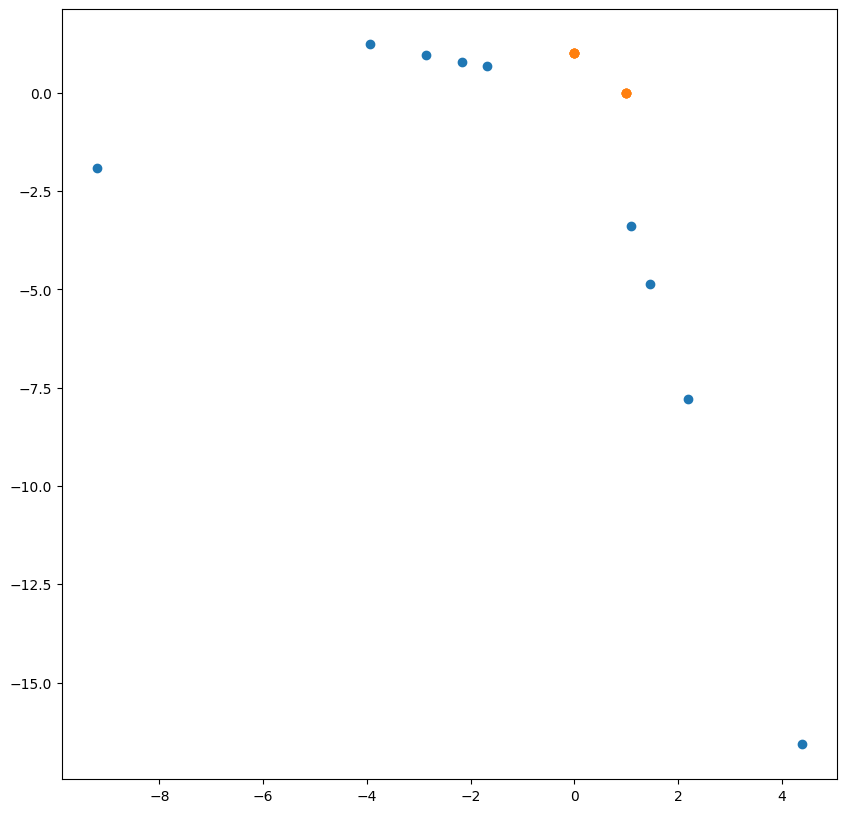

In [39]:
import matplotlib.pyplot as plt

fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot()
# plot Y . first element of Y is Y[i][0]
ax.scatter([Y[i][0] for i in range(T)], [Y[i][1] for i in range(T)], label="Y")
ax.scatter([X[i][0] for i in range(T)], [X[i][1] for i in range(T)], label="X")

In [36]:
!pip install matplotlib

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.6/8.6 MB 86.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.9/4.9 MB 89.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.4/1.4 MB 84.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.3/4.3 MB 116.2 MB/s eta 0:00:00
